<a href="https://colab.research.google.com/github/ryanas97/ml/blob/master/FinalAssignment/ML_Final_(GRU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DATASET PREPARATION

### Import Library.

In [2]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense, GRU
from keras.models import Model
from nltk.translate.bleu_score import corpus_bleu


Using TensorFlow backend.


In [0]:
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [4]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  gru_weights.h5  lstm_weights.h5	rnn_weights.h5	sample_data


### Pre-process Dataset

In [5]:
line= pd.read_table('/content/drive/My Drive/de.txt', names=['deu'], nrows=19250, skip_blank_lines=False)
line2= pd.read_table('/content/drive/My Drive/en.txt', names=['en'], nrows=19250, skip_blank_lines=False)
# print(line[::-1])
# print(lines[::-1])
linesx = pd.concat([line, line2], axis=1)
lines = pd.concat([linesx, linesx])  
print(lines[::])

                                                     deu                                                 en
0      SAN FRANCISCO – Es war noch nie leicht, ein ra...  SAN FRANCISCO – It has never been easy to have...
1      In letzter Zeit allerdings ist dies schwierige...  Lately, with gold prices up more than 300% ove...
2      Erst letzten Dezember verfassten meine Kollege...  Just last December, fellow economists Martin F...
3                      Und es kam, wie es kommen musste.                              Wouldn’t you know it?
4      Seit der Veröffentlichung ihrer Artikel ist de...  Since their articles appeared, the price of go...
5      Jüngst erreichte er sogar ein Rekordhoch von 1...  Gold prices even hit a record-high $1,300 rece...
6      Im letzten Dezember argumentierten die Goldbug...  Last December, many gold bugs were arguing tha...
7      Beflügelt aufgrund des anhaltenden Aufwärtstre...  Now, emboldened by continuing appreciation, so...
8      Ein erfolgreicher Gol

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


In [0]:
lines = lines.dropna()

In [0]:
# Remove special characters
lines.en=lines.en.apply(lambda x: re.sub("'", '', x))
lines.en=lines.en.apply(lambda x: re.sub("’", '', x))
lines.en=lines.en.apply(lambda x: re.sub("“", '', x))
lines.en=lines.en.apply(lambda x: re.sub("”", '', x))
lines.en=lines.en.apply(lambda x: re.sub("„", '', x))
lines.en=lines.en.apply(lambda x: re.sub("–", '', x))

lines.deu=lines.deu.apply(lambda x: re.sub("'", '', x))
lines.deu=lines.deu.apply(lambda x: re.sub("’", '', x))
lines.deu=lines.deu.apply(lambda x: re.sub("“", '', x))
lines.deu=lines.deu.apply(lambda x: re.sub("”", '', x))
lines.deu=lines.deu.apply(lambda x: re.sub("„", '', x))
lines.deu=lines.deu.apply(lambda x: re.sub("–", '', x))


In [0]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.en=lines.en.apply(lambda x: x.translate(remove_digits))
lines.deu = lines.deu.apply(lambda x: x.translate(remove_digits))

In [0]:
# Remove extra spaces
lines.en=lines.en.apply(lambda x: x.strip())
lines.deu=lines.deu.apply(lambda x: x.strip())
lines.en=lines.en.apply(lambda x: re.sub(" +", " ", x))
lines.deu=lines.deu.apply(lambda x: re.sub(" +", " ", x))

In [0]:
exclude = set(string.punctuation) 
# Remove punctuations
lines.en=lines.en.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.deu=lines.deu.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [0]:
lines = lines.dropna()

In [0]:
# Lowercase all characters
lines.en=lines.en.apply(lambda x: x.lower())
lines.deu=lines.deu.apply(lambda x: x.lower())

In [0]:
# Filter Word Length
min_word_len = 1
max_word_len = 18
lines['deu'] = lines['deu'].astype('str')
lines['en'] = lines['en'].astype('str')
mask = ((lines['deu'].str.split().str.len() <= max_word_len) & (lines['en'].str.split().str.len() <= max_word_len)& ((lines['deu'].str.split().str.len() >= min_word_len) & (lines['en'].str.split().str.len() >= min_word_len)))
# print(mask)
lines = lines.loc[mask]

In [0]:
# Add start and end tokens to target sequences
lines.en = lines.en.apply(lambda x : 'START_ '+ x + ' _END')

In [15]:
print("Total Sentences EN : ",len(lines.en))
print("Total Sentences DEU : ",len(lines.deu))

Total Sentences EN :  14004
Total Sentences DEU :  14004


  ### Visualize Data.

In [16]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in lines.en:
    eng_l.append(len(i.split()))

for i in lines.deu:
    deu_l.append(len(i.split()))
    
print((eng_l)) 
print((deu_l))

[19, 6, 15, 9, 16, 19, 9, 16, 16, 12, 16, 14, 14, 18, 19, 18, 19, 11, 14, 18, 11, 12, 14, 9, 8, 10, 16, 15, 14, 15, 20, 9, 5, 14, 19, 14, 16, 6, 9, 19, 15, 7, 17, 11, 10, 17, 10, 17, 18, 12, 18, 14, 20, 14, 9, 15, 12, 12, 8, 9, 15, 8, 8, 10, 11, 13, 11, 15, 7, 14, 15, 14, 8, 12, 17, 19, 18, 7, 14, 14, 12, 20, 11, 11, 15, 12, 16, 14, 9, 11, 6, 11, 12, 15, 11, 15, 18, 20, 17, 16, 14, 10, 18, 5, 18, 8, 13, 12, 16, 14, 14, 20, 18, 18, 11, 16, 8, 13, 12, 18, 11, 9, 14, 15, 18, 16, 20, 12, 14, 12, 10, 14, 19, 17, 14, 10, 13, 8, 10, 19, 18, 20, 17, 17, 19, 20, 14, 17, 14, 14, 17, 20, 8, 10, 12, 7, 19, 19, 19, 18, 7, 6, 17, 12, 6, 9, 15, 12, 18, 12, 14, 17, 20, 4, 11, 19, 18, 9, 19, 17, 16, 16, 8, 19, 12, 18, 8, 15, 14, 20, 11, 16, 18, 15, 12, 10, 16, 9, 14, 18, 15, 16, 13, 7, 9, 11, 12, 7, 13, 12, 8, 19, 18, 17, 6, 20, 17, 18, 9, 20, 15, 19, 20, 15, 11, 11, 17, 13, 14, 18, 12, 18, 18, 16, 19, 13, 16, 19, 9, 14, 18, 17, 19, 17, 17, 18, 18, 11, 19, 12, 19, 13, 17, 17, 6, 16, 12, 11, 16, 13, 17,

In [17]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
print(len(eng_l),len(deu_l))
print(max(eng_l),max(deu_l))

14004 14004
20 18


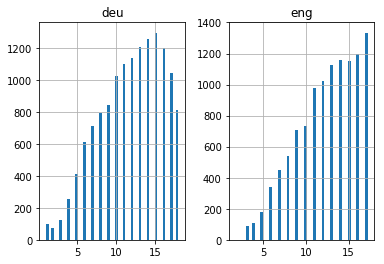

In [18]:
length_df.hist(bins = 50)
plt.xlim(min_word_len, max_word_len)
plt.show()

In [19]:
lines.sample(10)

,deu,en
17161,der dollar dagegen scheint für die sicherere w...,START_ the dollar on the other hand looks like...
7825,wo sind die haftbefehle für bush und cheney,START_ where indeed are the arrest warrants fo...
14785,stehen wir am beginn einer neuen annäherung zw...,START_ is a new alignment between india and ch...
1559,der vertrauensrückgang betraf banken die börse...,START_ that fall in confidence affected banks ...
7591,europa ist bereits ein starker gasverbraucher ...,START_ europe is already a heavy user of gas b...
9836,die politische partizipation der muslime in sc...,START_ muslim political participation in subsa...
13667,in europa werden vermehrt überschwemmungen auf...,START_ flooding in europe is likely to intensi...
12692,außerdem wird dieser zuwachs höchstwahrscheinl...,START_ furthermore the country on which this i...
13580,die übertragung des vorsitzes der unmenschenre...,START_ the choice of libya to chair the un hum...
14707,man hatte den eindruck als wäre der iwf zum ve...,START_ the imf seemed condemned to run out of ...


  ### Training Preparation.

In [0]:
# Vocabulary of English
all_en_words=set()
for en in lines.en:
    for word in en.split():
        if word not in all_en_words:
            all_en_words.add(word)

# Vocabulary of Deutsch 
all_deu_words=set()
for deu in lines.deu:
    for word in deu.split():
        if word not in all_deu_words:
            all_deu_words.add(word)

In [21]:
# Max Length of source sequence
max_length_src = np.max(eng_l)
max_length_src

20

In [22]:
# Max Length of target sequence
max_length_tar = np.max(deu_l) + 1
max_length_tar

19

In [23]:
input_words = sorted(list(all_deu_words))
target_words = sorted(list(all_en_words))
num_encoder_tokens = len(all_deu_words)
num_decoder_tokens = len(all_en_words)
num_encoder_tokens, num_decoder_tokens

(14617, 10003)

In [24]:
num_decoder_tokens += 1 # For zero padding
num_decoder_tokens

10004

In [25]:
print("Total Sentences EN : ",len(lines.en))
print("Total Sentences DEU : ",len(lines.deu))

Total Sentences EN :  14004
Total Sentences DEU :  14004


In [0]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [27]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())
print(reverse_input_char_index)
print(reverse_target_char_index)

{1: 'a', 2: 'ab', 3: 'abba', 4: 'abbas', 5: 'abbau', 6: 'abbauen', 7: 'abbekommen', 8: 'abchasien', 9: 'abdrücken', 10: 'abduktiv', 11: 'abduktive', 12: 'abe', 13: 'abebben', 14: 'abends', 15: 'abenteuerlichen', 16: 'aber', 17: 'abfedernde', 18: 'abfedert', 19: 'abfederung', 20: 'abfederungalleineiner', 21: 'abfeuern', 22: 'abfließen', 23: 'abfluss', 24: 'abgaben', 25: 'abgang', 26: 'abgebaut', 27: 'abgeben', 28: 'abgefunden', 29: 'abgegeben', 30: 'abgehalten', 31: 'abgehoben', 32: 'abgeht', 33: 'abgelaufen', 34: 'abgelegenen', 35: 'abgelegt', 36: 'abgelehnt', 37: 'abgeleistet', 38: 'abgeleitet', 39: 'abgelenkt', 40: 'abgemacht', 41: 'abgeordnete', 42: 'abgerutscht', 43: 'abgeschafft', 44: 'abgeschlossen', 45: 'abgeschotteten', 46: 'abgeschworen', 47: 'abgesehen', 48: 'abgesichert', 49: 'abgestaubt', 50: 'abgestempelt', 51: 'abgestimmt', 52: 'abgestraft', 53: 'abgetan', 54: 'abgewehrt', 55: 'abgewickelt', 56: 'abgeändert', 57: 'abgibt', 58: 'abgleiten', 59: 'abgleitet', 60: 'abgrund', 

In [28]:
lines = shuffle(lines)
lines.head(10)

,deu,en
9171,das sollten sie auch nicht müssen,START_ nor should they have to _END
498,doch die einigung hat drei wichtige fehler,START_ but the agreement has three major flaws...
19053,es gab die immobilienblase und darlehen wurden...,START_ there was a housing bubble and loans we...
16795,inhalt,START_ content _END
15957,wo wird das enden,START_ where will it end _END
6071,in groben zügen müssen die ausgaben für forsch...,START_ in broad strokes this requires a delibe...
9587,dagegen entfallen auf den handel zwischen afri...,START_ by contrast trade among african countri...
9878,dieses problem wird sich nach arafats tod nich...,START_ this problem will not go away when araf...
7489,if you do not yet have an account please register,START_ if you do not yet have an account pleas...
4431,die katarer haben den iran bei der nutzung des...,START_ the qataris have outstripped them in ex...


In [29]:
# Train - Test Split
X, y = lines.deu, lines.en
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((12603,), (1401,))

### Data Batch Generator Function


In [0]:
def generate_batch(X = X_train, y = y_train):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)



```
# This is formatted as code
```

### Encoder - Decoder GRU

 


In [31]:
latent_dim = 200

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_gru = GRU(latent_dim, return_state=True)
encoder_outputs, state_h = encoder_gru(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_gru = GRU(latent_dim, return_state=True, return_sequences=True)
decoder_outputs,_ = decoder_gru(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

### Model Execution

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [34]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 384
epochs = 100
time_callback = TimeHistory()

history = model.fit_generator(generator = generate_batch(X_train, y_train),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs, 
                    callbacks=[time_callback],
                    validation_data = generate_batch(X_test, y_test),
                    validation_steps = val_samples//batch_size)
model.save_weights('gru_weights.h5')

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
32/32 [==============================] - 22s 703ms/step - loss: 7.2362 - acc: 0.0921 - val_loss: 6.7442 - val_acc: 0.1076
Epoch 2/100
32/32 [==============================] - 16s 500ms/step - loss: 6.6368 - acc: 0.1079 - val_loss: 6.5884 - val_acc: 0.1105
Epoch 3/100
32/32 [==============================] - 16s 500ms/step - loss: 6.4552 - acc: 0.1128 - val_loss: 6.4780 - val_acc: 0.1135
Epoch 4/100
32/32 [==============================] - 16s 496ms/step - loss: 6.2843 - acc: 0.1244 - val_loss: 6.3161 - val_acc: 0.1244
Epoch 5/100
32/32 [==============================] - 16s 495ms/step - loss: 6.1376 - acc: 0.1355 - val_loss: 6.2440 - val_acc: 0.1338
Epoch 6/100
32/32 [==============================] - 16s 501ms/step - loss: 6.0048 - acc: 0.1467 - val_loss: 6.1062 - val_acc: 0.1508
Epoch 7/100
32/32 [==============================] - 16s 497ms/step - 

### Load the weights

In [0]:
model.load_weights('gru_weights.h5')

### Inference Setup

In [0]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2 = decoder_gru(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


### Decode sample sequences

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = [encoder_model.predict(input_seq)]
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0] = target_token_index['START_']
    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0] = sampled_token_index

        # Update states
        states_value = [h]

    return decoded_sentence

#### Result and Evaluation on Train Dataset

In [0]:
batch_size=1

In [0]:
train_gen = generate_batch(X_train, y_train)

In [40]:
ref = []
can = []

for k in range(50):
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input Deutch sentence:', X_train[k:k+1].values[0])
    print('Actual English Translation:', y_train[k:k+1].values[0][6:-4])
    ref.append([y_train[k:k+1].values[0][6:-4].split()])
    print('Predicted English Translation:', decoded_sentence[:-4])
    can.append(decoded_sentence[:-4].split())
    print("-----------------------------------------")
    
print(ref)
print(can)

Input Deutch sentence: die übertragungseffekte durch handelsverbindungen sind nicht weniger besorgniserregend
Actual English Translation:  the transmission effects through trade linkages are just as worrying 
Predicted English Translation:  the transmission effects through trade linkages
-----------------------------------------
Input Deutch sentence: dies hat alle drei länder für die zentrale bedeutung des gemeinschaftlichen aspekts blind gemacht
Actual English Translation:  this blinded all three countries to the centrality of community 
Predicted English Translation:  this blinded all three countries to the centra
-----------------------------------------
Input Deutch sentence: unsere energieunternehmen versorgen ein territorium von der größe frankreichs sie werden allesamt privatisiert werden
Actual English Translation:  our energy companies service a territory the size of france they will all be privatized 
Predicted English Translation:  our energy companies service a territory t

In [41]:
score = corpus_bleu(ref, can)
print("BLEU Score GRU : ", score)

BLEU Score GRU :  0.4120471008944862


## MODEL EVALUATION

In [0]:
val_gen = generate_batch(X_test, y_test)

In [43]:
ref = []
can = []

for k in range(len(X_test)):
    (input_seq, actual_output), _ = next(val_gen)
    print('Input Deutsch sentence:', X_test[k:k+1].values[0])
    print('Actual English Translation:', y_test[k:k+1].values[0][6:-4])
    ref.append([y_test[k:k+1].values[0][6:-4].split()])
    decoded_sentence = decode_sequence(input_seq)
    print('Predicted English Translation:', decoded_sentence[:-4])
    can.append(decoded_sentence[:-4].split())
    print("---------------------------------------------------------------------------------")


Input Deutsch sentence: das ist kutschma nicht ganz im gegenteil
Actual English Translation:  kuchma is not 
Predicted English Translation:  to wait 
---------------------------------------------------------------------------------
Input Deutsch sentence: in den asiatischen ländern hingegen einschließlich china bleibt der optimismus ungebrochen
Actual English Translation:  however in the asian countries including china the optimism is unbroken 
Predicted English Translation:  however in the union there have been the leadin
---------------------------------------------------------------------------------
Input Deutsch sentence: hilfeleistung für arme länder
Actual English Translation:  help poor countries 
Predicted English Translation:  other feedback loops pose the us dollar 
---------------------------------------------------------------------------------
Input Deutsch sentence: das meiste gewicht bleibt aber die weiteren lebensaussichten verschlechtern sich erheblich
Actual English 

## GRAPH AND COMPUTATION TIME

Total Computation Time (GRU) :  1603.9190664291382


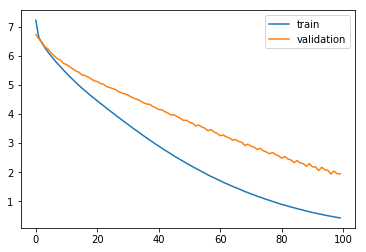

<Figure size 432x288 with 0 Axes>

In [44]:
print("Total Computation Time (GRU) : ", sum(time_callback.times))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
fig = plt.figure()
plt.show()

In [45]:
score = corpus_bleu(ref, can)
print("BLEU Score GRU : ", score)

BLEU Score GRU :  0.1358498813652344
